In [73]:
import numpy as np
import sys
sys.path.append('../')
from  momentBasedReco import *
import matplotlib.pyplot as plt
from utils import *
import qutip as qt

In [74]:
data = matlab2dict('../Data/QuadratureDistribution_Digitizer/16-Feb-2024/20240216_132619_QuadratureDistributions_ModeMatching.mat')
phase_corr = np.pi/4

N0 = 4.935#5.061

scale = np.sqrt(np.var(np.concatenate([data['I1_vacuum'], data['Q1_vacuum']])) / (1/2 + N0/2))
data['I1_vacuum'] = data['I1_vacuum']/scale
data['Q1_vacuum'] = data['Q1_vacuum']/scale
data['I1_pi'] = data['I1_pi']/scale
data['Q1_pi'] = data['Q1_pi']/scale
data['I1_pi_half'] = data['I1_pi_half']/scale
data['Q1_pi_half'] = data['Q1_pi_half']/scale


S_vac = (data['I1_vacuum'] + 1j*data['Q1_vacuum'])*np.exp(1j*phase_corr)
S_pi = (data['I1_pi'] + 1j*data['Q1_pi'])*np.exp(1j*phase_corr)
S_pi_half = (data['I1_pi_half'] + 1j*data['Q1_pi_half'])*np.exp(1j*phase_corr)


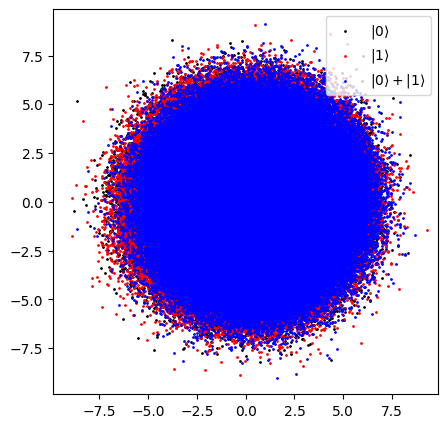

In [75]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(S_vac.real, S_vac.imag, label='$|0\\rangle$', color='black', s=1)
ax.scatter(S_pi.real, S_pi.imag, label='$|1\\rangle$', color='red', s=1)
ax.scatter(S_pi_half.real, S_pi_half.imag, label='$|0\\rangle + |1\\rangle$', color='blue', s=1)
ax.set_xlim([-2*N0, 2*N0])
ax.set_ylim([-2*N0, 2*N0])
ax.set_aspect('equal')
ax.legend(loc='upper right')

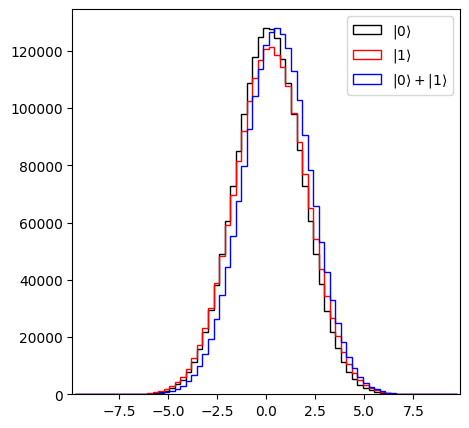

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
bins=70
hist_vac, x_e, y_e = np.histogram2d(S_vac.real, S_vac.imag, bins=bins, range=[[-2*N0, 2*N0], [-2*N0, 2*N0]])
hist_pi, x_e, y_e = np.histogram2d(S_pi.real, S_pi.imag, bins=bins, range=[[-2*N0, 2*N0], [-2*N0, 2*N0]])
hist_pi_half, x_e, y_e = np.histogram2d(S_pi_half.real, S_pi_half.imag, bins=bins, range=[[-2*N0, 2*N0], [-2*N0, 2*N0]])
x, y = [x_e[i]/2 + x_e[i+1]/2 for i in range(len(x_e)-1)], [y_e[i]/2 + y_e[i+1]/2 for i in range(len(y_e)-1)]

ax.hist(x, x, weights=np.sum(hist_vac, axis=1), label='$|0\\rangle$',edgecolor='black', facecolor=None, histtype='step')
ax.hist(x, x, weights=np.sum(hist_pi, axis=1), label='$|1\\rangle$', edgecolor='red', facecolor=None, histtype='step')
ax.hist(x, x, weights=np.sum(hist_pi_half, axis=1), label='$|0\\rangle + |1\\rangle$', edgecolor='blue', facecolor=None, histtype='step')
# ax.hist(S_pi.real, bins, label='$|1\\rangle$', edgecolor='red', facecolor=None, histtype='step')
# ax.hist(S_pi_half.real, bins, label='$|0\\rangle + |1\\rangle$', edgecolor='blue', facecolor=None, histtype='step')

ax.set_xlim([-2*N0, 2*N0])

ax.legend(loc='best')

# Moments based reconstruction

In [77]:
# Compute measured moments up to order 4
max_order = 4

# Compute noise moments
vac_moments, vac_moments_unc  = calculate_moments_uncertainty_vectorized(S_vac, max_order)

# Compute measured moments up to order 4
pi_moments, pi_moments_unc  = calculate_moments_uncertainty_vectorized(S_pi, max_order)
pi_half_moments, pi_half_moments_unc  = calculate_moments_uncertainty_vectorized(S_pi_half, max_order)

In [78]:
# Compute signal moments with vectorized MonteCarlo
MCsamples = 10000
gnd_moments, gnd_moments_unc  = extract_a_moments_uncertainty_vectorized(vac_moments, vac_moments_unc, vac_moments, max_order, MCsamples)
sig_pi_moments, sig_pi_moments_unc  = extract_a_moments_uncertainty_vectorized(pi_moments, pi_moments_unc, vac_moments, max_order, MCsamples) 
sig_pi_half_moments, sig_pi_half_moments_unc  = extract_a_moments_uncertainty_vectorized(pi_half_moments, pi_half_moments_unc, vac_moments, max_order, MCsamples) 

In [79]:
sig_pi_moments

array([[ 1.        ,  0.07548158,  0.00876674,  0.01292693,  0.03531076],
       [ 0.07545626,  0.62296066, -0.0230263 , -0.03824942, -0.19506758],
       [ 0.00867689, -0.02261517,  0.02405672, -0.14502352,  0.99959523],
       [ 0.01269591, -0.0384949 , -0.1292133 ,  2.4411789 ,  3.62663807],
       [ 0.03780441, -0.15755142,  1.07244263,  2.14755457,  4.56308184]])

In [80]:
d = 10

#Maximum Likelihood reconstruction
gnd_rec_MBR = moments_to_density_matrix_ml(gnd_moments, gnd_moments_unc, d)
sig_pi_rec_MBR = moments_to_density_matrix_ml(sig_pi_moments, sig_pi_moments_unc, d)
sig_pi_half_rec_MBR = moments_to_density_matrix_ml(sig_pi_half_moments, sig_pi_half_moments_unc, d)


c:\Users\labranca\Documents\EnvPython\quantumEnv\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Save results

In [81]:
np.savez(f"../Results/data_MBR_N0-{N0*1000:.0f}.npz", rho_gnd=gnd_rec_MBR, rho_sig_pi=sig_pi_rec_MBR, rho_sig_pi_half=sig_pi_half_rec_MBR, moments_vac=vac_moments, moments_vac_unc=vac_moments_unc, moments_pi=pi_moments, moments_pi_unc=pi_moments_unc, moments_pi_half=pi_half_moments, moments_pi_half_unc=pi_half_moments_unc, moments_sig_pi_half=sig_pi_half_moments, moments_sig_pi_half_unc=sig_pi_half_moments_unc, moments_sig_pi=sig_pi_moments, moments_sig_pi_unc=sig_pi_moments_unc)

## Plots

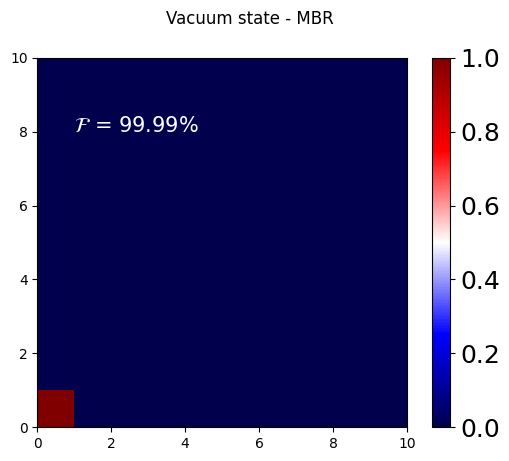

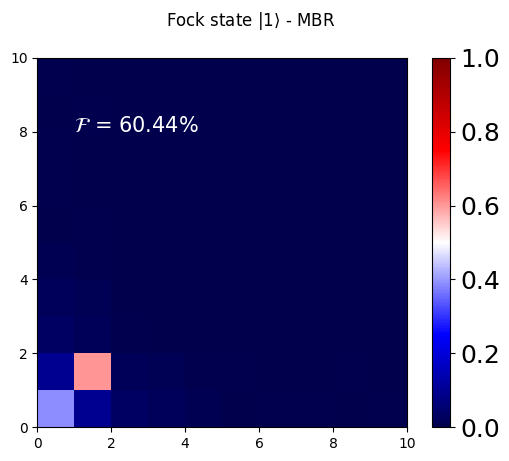

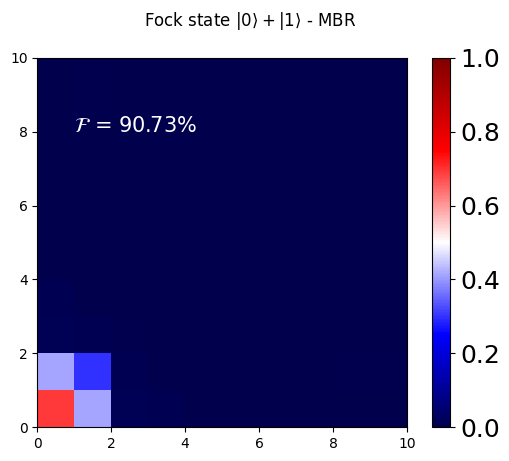

In [82]:
fig, ax = plt.subplots()
fig.suptitle('Vacuum state - MBR')
cm = ax.pcolormesh(np.abs(gnd_rec_MBR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
ax.text(1,d-2,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(gnd_rec_MBR), qt.fock_dm(d,0))**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - MBR')
cm = ax.pcolormesh(np.abs(sig_pi_rec_MBR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
ax.text(1,d-2,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_pi_rec_MBR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|0 \\rangle + |1 \\rangle$ - MBR')
cm = ax.pcolormesh(np.abs(sig_pi_half_rec_MBR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
st = np.sqrt(1/2) * (qt.basis(d,1) +  qt.basis(d,0))
ax.text(1,d-2,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_pi_half_rec_MBR), st*st.dag())**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')

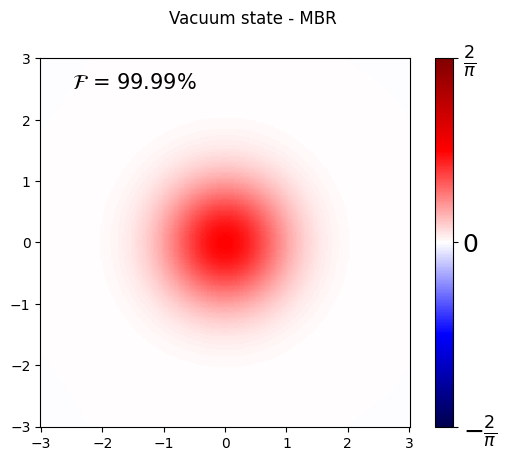

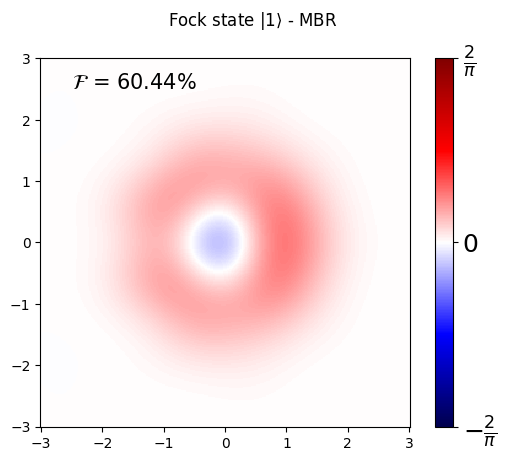

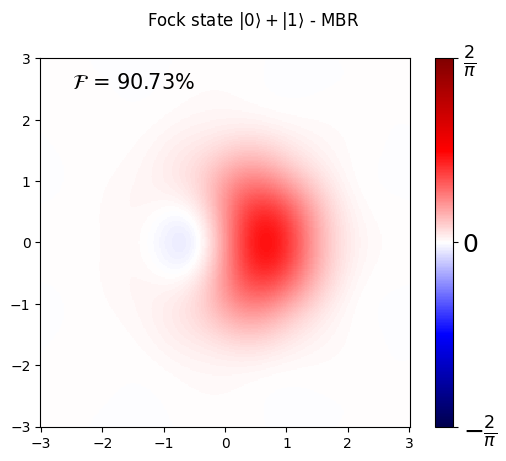

In [83]:
x_s, p_s = np.linspace(-3,3,301), np.linspace(-3,3,301)

fig, ax = plt.subplots()
fig.suptitle('Vacuum state - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(gnd_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(gnd_rec_MBR), qt.fock_dm(d,0))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_pi_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_pi_rec_MBR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|0 \\rangle + |1 \\rangle$ - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_pi_half_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
st = np.sqrt(1/2) * (qt.basis(d,1) +  qt.basis(d,0))
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_pi_half_rec_MBR), st*st.dag())**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

In [84]:
print('g2 thermal:', g2_from_moments_with_uncertainty(vac_moments, vac_moments_unc)[0], ' +/- ', g2_from_moments_with_uncertainty(vac_moments, vac_moments_unc)[1])
print('g2 pi:', g2_from_moments_with_uncertainty(sig_pi_moments, sig_pi_moments_unc)[0], ' +/- ', g2_from_moments_with_uncertainty(sig_pi_moments, sig_pi_moments_unc)[1])
print('g2 pi half:', g2_from_moments_with_uncertainty(sig_pi_half_moments, sig_pi_half_moments_unc)[0], ' +/- ', g2_from_moments_with_uncertainty(sig_pi_half_moments, sig_pi_half_moments_unc)[1])

print('g2 pi:', g2_from_density_matrix(sig_pi_rec_MBR))
print('g2 pi half:', g2_from_density_matrix(sig_pi_half_rec_MBR))

g2 thermal: 2.004517422967528  +/-  0.004303190592285194
g2 pi: 0.061989083962395344  +/-  0.4512270352804108
g2 pi half: 0.8896597301300595  +/-  1.565788016214525
g2 pi: 0.1043198646448128
g2 pi half: 0.9737787893438439


# $R \rho R$ reconstruction

In [ ]:
from RmatrixBasedReco import *
d = 60
nbins = 35

tol = 1
dil = 1e-2

counts, alphas = prepare_histograms(np.squeeze(S_vac), nbins)
povm_list = [coherent_state_povm(alpha, d) for alpha in alphas]
therm_rec_RrhorR, therm_lik_RrhorR, therm_eig_RrhorR, therm_fid_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=100000, useG=True, dilution=dil, tol=tol, improvement_tol=1e-8, patience=100, track_likelihood=True, rho_exact=qt.thermal_dm(d,N0).full())

fig, ax = plt.subplots(3, 1, figsize=(8, 7))
fig.suptitle('Detector State Reconstruction')
ax[0].plot(np.arange(1, len(therm_lik_RrhorR)+1), therm_lik_RrhorR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(therm_eig_RrhorR)+1), np.abs(therm_eig_RrhorR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  

ax[2].plot(np.arange(1, len(therm_fid_RrhoR)+1), np.abs(np.array(therm_fid_RrhoR)-1))
ax[2].set_title('$1 - \\mathcal{F}$')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].grid()
fig.tight_layout()

In [ ]:
tol = 1e-3
dil = None

prior_rho = np.zeros((d,d), dtype=complex) 
prior_rho[0:3,0:3] = 1
prior_rho = prior_rho/np.trace(prior_rho)

counts, alphas = prepare_histograms(np.squeeze(S_pi), nbins)
povm_list = [displaced_thermal_povm(-alpha.conj(), N0, d) for alpha in alphas]
sig_pi_rec_RrhoR, sig_pi_lik_RrhoR, sig_pi_eig_RrhoR, sig_pi_fid_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), init_rho=prior_rho, max_iter=500000, useG=True, dilution=dil, tol=tol, improvement_tol=1e-12, patience=1000, track_likelihood=True, rho_exact=qt.fock_dm(d,1).full())   
fig, ax = plt.subplots(3, 1, figsize=(8, 7))
fig.suptitle('Signal State Reconstruction')
ax[0].plot(np.arange(1, len(sig_pi_lik_RrhoR)+1), sig_pi_lik_RrhoR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(sig_pi_eig_RrhoR)+1), np.abs(sig_pi_eig_RrhoR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  

ax[2].plot(np.arange(1, len(sig_pi_fid_RrhoR)+1), np.abs(np.array(sig_pi_fid_RrhoR)-1))
ax[2].set_title('$1 - \\mathcal{F}$')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].grid()
fig.tight_layout()



NameError: name 'np' is not defined

In [ ]:
tol = 1e-3
dil = None

prior_rho = np.zeros((d,d), dtype=complex) 
prior_rho[0:3,0:3] = 1
prior_rho = prior_rho/np.trace(prior_rho)

counts, alphas = prepare_histograms(np.squeeze(S_pi_half), nbins)
povm_list = [displaced_thermal_povm(-alpha.conj(), N0, d) for alpha in alphas]
st = np.sqrt(1/2) * (qt.basis(d,1) +  qt.basis(d,0))
sig_pi_half_rec_RrhoR, sig_pi_half_lik_RrhoR, sig_pi_half_eig_RrhoR, sig_pi_half_fid_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), init_rho=prior_rho, max_iter=500000, useG=True, dilution=dil, tol=tol, improvement_tol=1e-12 , patience=1000, track_likelihood=True, rho_exact=(st*st.dag()).full())
fig, ax = plt.subplots(3, 1, figsize=(8, 7))
fig.suptitle('Signal State Reconstruction')
ax[0].plot(np.arange(1, len(sig_pi_half_lik_RrhoR)+1), sig_pi_half_lik_RrhoR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(sig_pi_half_eig_RrhoR)+1), np.abs(sig_pi_half_eig_RrhoR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  

ax[2].plot(np.arange(1, len(sig_pi_half_fid_RrhoR)+1), np.abs(np.array(sig_pi_half_fid_RrhoR)-1))
ax[2].set_title('$1 - \\mathcal{F}$')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].grid()
fig.tight_layout()

KeyboardInterrupt: 

### Save results

In [ ]:
np.savez(f"../Results/data_RrhoR_N0{N0*1000:.0f}.npz", rho_therm=therm_rec_RrhorR, eig_therm=therm_eig_RrhorR, lik_therm=therm_lik_RrhorR, fid_therm=therm_fid_RrhoR, rho_sig_pi=sig_pi_rec_RrhoR, eig_sig_pi=sig_pi_eig_RrhoR, lik_sig_pi=sig_pi_lik_RrhoR, fid_sig_pi=sig_pi_fid_RrhoR, rho_sig_pi_half=sig_pi_half_rec_RrhoR, eig_sig_pi_half=sig_pi_half_eig_RrhoR, lik_sig_pi_half=sig_pi_half_lik_RrhoR, fid_sig_pi_half=sig_pi_half_fid_RrhoR)

## Plots

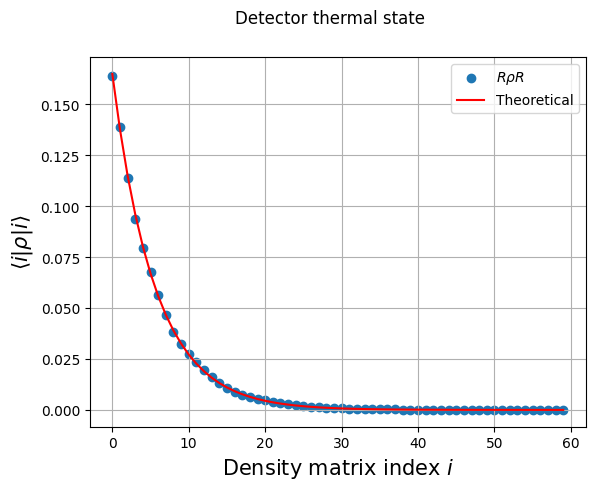

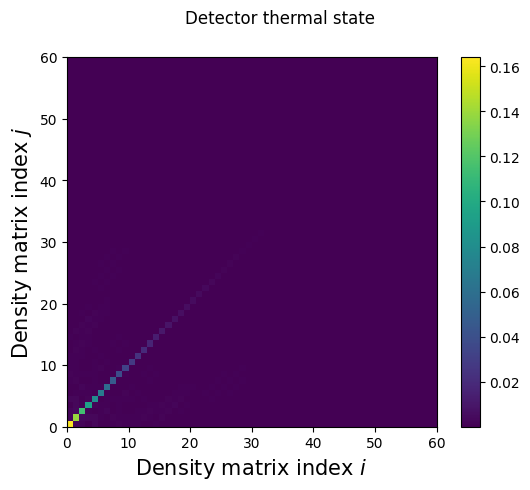

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Detector thermal state')
ax.scatter(np.arange(0,d),np.diagonal(np.abs(therm_rec_RrhorR)), label='$R \\rho R$')
ax.plot(np.arange(0,d), np.diagonal(np.abs(qt.thermal_dm(d, N0).full())), color='red', label='Theoretical')
ax.set_xlabel('Density matrix index $i$', fontsize=15)
ax.set_ylabel('$\\langle i|\\rho|i \\rangle$', fontsize=15)
ax.grid()
ax.legend()


fig, ax = plt.subplots()
fig.suptitle('Detector thermal state')
cb = ax.pcolormesh(np.abs(therm_rec_RrhorR))
fig.colorbar(cb)
ax.set_xlabel('Density matrix index $i$', fontsize=15)
ax.set_ylabel('Density matrix index $j$', fontsize=15)
ax.set_aspect('equal')

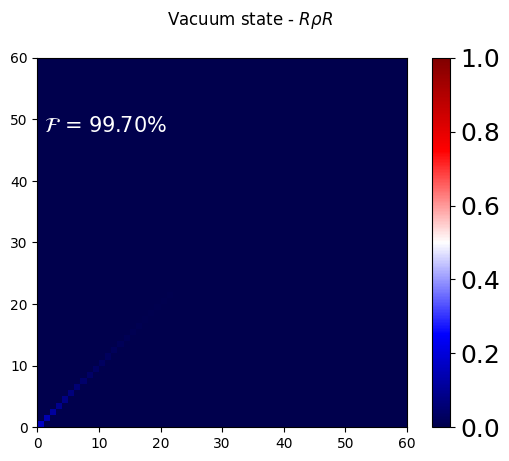

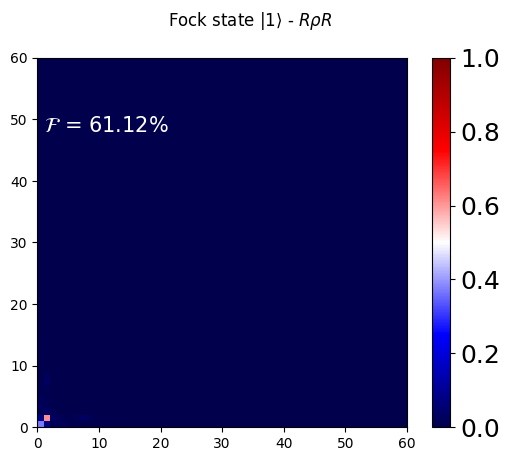

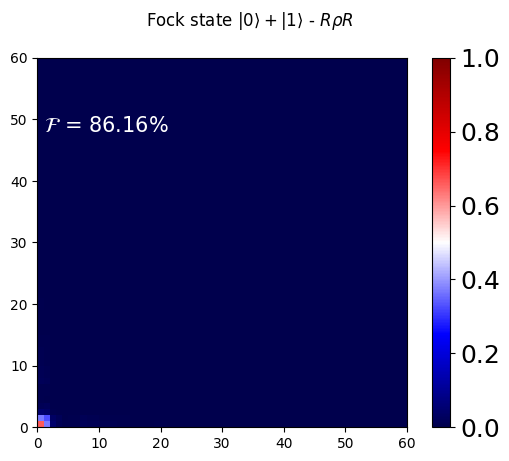

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Vacuum state - $R \\rho R$')
cm = ax.pcolormesh(np.abs(therm_rec_RrhorR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
ax.text(1,d*0.8,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(therm_rec_RrhorR), qt.thermal_dm(d,N0))**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - $R \\rho R$')
cm = ax.pcolormesh(np.abs(sig_pi_rec_RrhoR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
ax.text(1,d*0.8,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_pi_rec_RrhoR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|0 \\rangle + |1 \\rangle$ - $R \\rho R$')
cm = ax.pcolormesh(np.abs(sig_pi_half_rec_RrhoR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
st = np.sqrt(1/2) * (qt.basis(d,1) +  qt.basis(d,0))
ax.text(1,d*0.8,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_pi_half_rec_RrhoR), st*st.dag())**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')

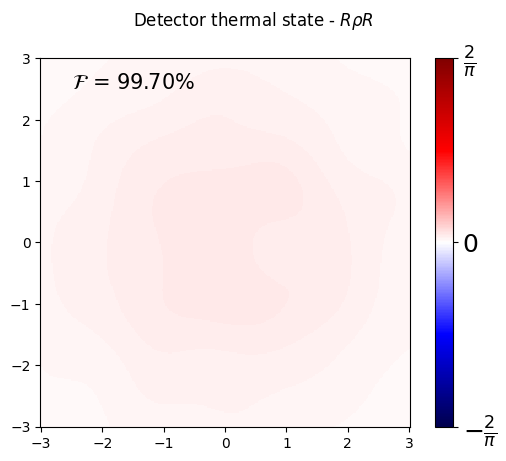

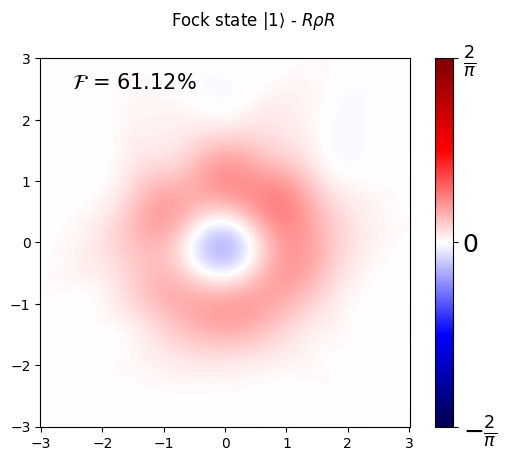

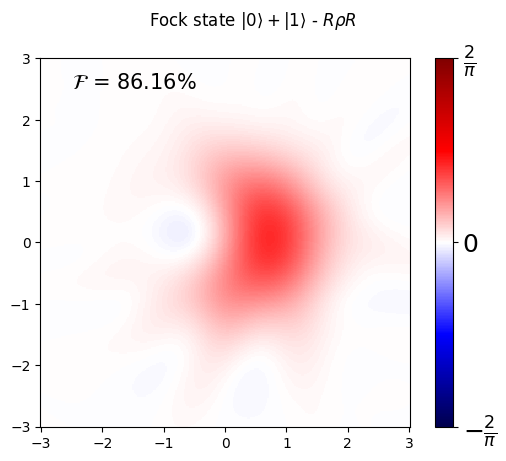

In [ ]:
x_s, p_s = np.linspace(-3,3,301), np.linspace(-3,3,301)

fig, ax = plt.subplots()
fig.suptitle('Detector thermal state - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(therm_rec_RrhorR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(therm_rec_RrhorR), qt.thermal_dm(d,N0))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_pi_rec_RrhoR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_pi_rec_RrhoR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|0 \\rangle + |1 \\rangle$ - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_pi_half_rec_RrhoR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
st = np.sqrt(1/2) * (qt.basis(d,1) + qt.basis(d,0))
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_pi_half_rec_RrhoR), st*st.dag())**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

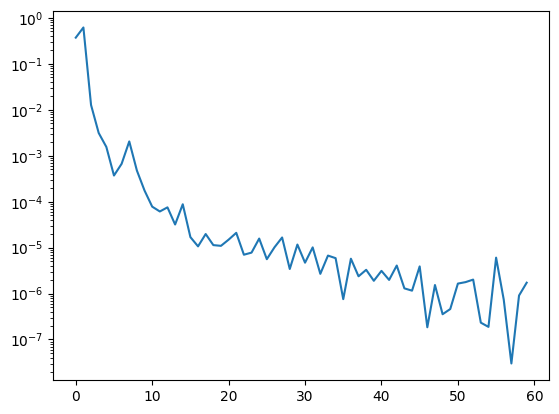

In [ ]:
plt.plot(np.diagonal(np.abs(sig_pi_rec_RrhoR)))
plt.yscale('log')

In [ ]:
g2_from_density_matrix(sig_pi_rec_RrhoR[:3,:3])

np.float64(0.06220750778279986)